In [1]:
# Based on https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynb
import torch
from torch.autograd import Variable

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt
import math, os



In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

def get_flatten_output():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, 2),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(64, 128, 4, 2),
        torch.nn.LeakyReLU(),
        Flatten(),
    )
    return model(Variable(torch.rand(2,1,28,28))).size()


def get_reshape_output():
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7*7*128),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(128, 64, 4, 2),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=3),
        torch.nn.Sigmoid()
    )
    return model(Variable(torch.rand(2,2))).size()




In [3]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x

In [4]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd



def compute_kl(z):
    mu=torch.mean(z)
    logvar=torch.log(torch.var(z))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl

In [5]:
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [6]:
model = Model(2)

In [7]:


z, x_reconstructed = model(Variable(torch.rand(1,1,28,28)))
z.size(), x_reconstructed.size()



(torch.Size([1, 2]), torch.Size([1, 1, 28, 28]))

In [8]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples


def train(
    dataloader,
    z_dim=2,
    n_epochs=10,
    use_cuda=torch.cuda.is_available(),
    print_every=100,
    plot_every=500,
    divergence='mmd'
):
    model = Model(z_dim)
    if use_cuda:
        model = model.cuda()
    #print(model)
    optimizer = torch.optim.Adam(model.parameters())
    i = -1
    for epoch in range(n_epochs):
        for images, labels in dataloader:
            i += 1
            optimizer.zero_grad()
            x = Variable(images, requires_grad=False)
            true_samples = Variable(
                torch.randn(200, z_dim),
                requires_grad=False
            )
            if use_cuda:
                x = x.cuda()
                true_samples = true_samples.cuda()
            z, x_reconstructed = model(x)
            if divergence=='mmd':
                mmd = compute_mmd(true_samples, z)
            else:
                mmd = compute_kl(z)
            nll = (x_reconstructed - x).pow(2).mean()
            loss = nll + mmd
            loss.backward()
            optimizer.step()
            if i % print_every == 0:
                print("Negative log likelihood is {:.5f}, mmd loss is {:.5f}".format(
                    nll.item(), mmd.item()))
            if i % plot_every == 0:
                gen_z = Variable(
                    torch.randn(100, z_dim),
                    requires_grad=False
                )
                if use_cuda:
                    gen_z = gen_z.cuda()
                samples = model.decoder(gen_z)
                samples = samples.permute(0,2,3,1).contiguous().cpu().data.numpy()
                plt.imshow(convert_to_display(samples), cmap='Greys_r')
                plt.show()
                
    return model


In [9]:
batch_size=200
mnist_train = torch.utils.data.DataLoader(
    MNIST("./tmp/MNIST", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=3,
    pin_memory=True
)

Negative log likelihood is 0.20833, mmd loss is 0.15264


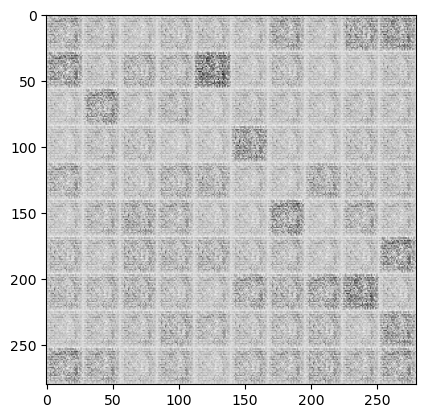

Negative log likelihood is 0.06656, mmd loss is 0.15922
Negative log likelihood is 0.06679, mmd loss is 0.18731
Negative log likelihood is 0.06068, mmd loss is 0.04280
Negative log likelihood is 0.05519, mmd loss is 0.01449
Negative log likelihood is 0.05542, mmd loss is 0.00467


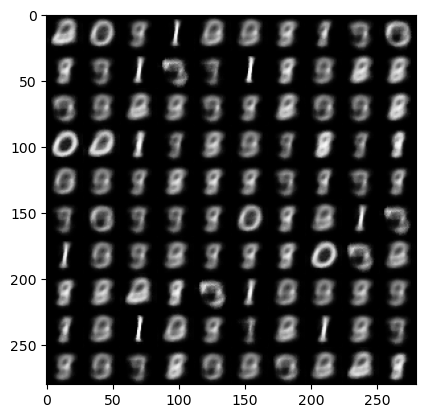

Negative log likelihood is 0.05347, mmd loss is 0.00314
Negative log likelihood is 0.05188, mmd loss is 0.01483
Negative log likelihood is 0.05011, mmd loss is 0.00387
Negative log likelihood is 0.04768, mmd loss is 0.00942
Negative log likelihood is 0.04717, mmd loss is 0.00241


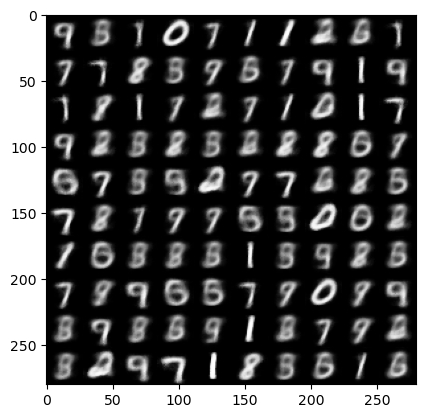

Negative log likelihood is 0.04669, mmd loss is 0.00301
Negative log likelihood is 0.04779, mmd loss is 0.01131
Negative log likelihood is 0.04326, mmd loss is 0.00502
Negative log likelihood is 0.04256, mmd loss is 0.00124
Negative log likelihood is 0.04309, mmd loss is 0.00329


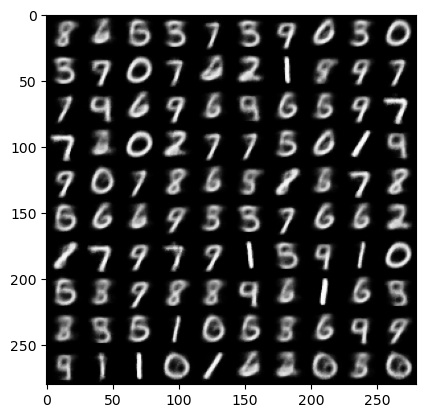

Negative log likelihood is 0.04528, mmd loss is 0.00917
Negative log likelihood is 0.04328, mmd loss is 0.00638
Negative log likelihood is 0.04287, mmd loss is 0.00267
Negative log likelihood is 0.04137, mmd loss is 0.01411
Negative log likelihood is 0.03998, mmd loss is 0.00762


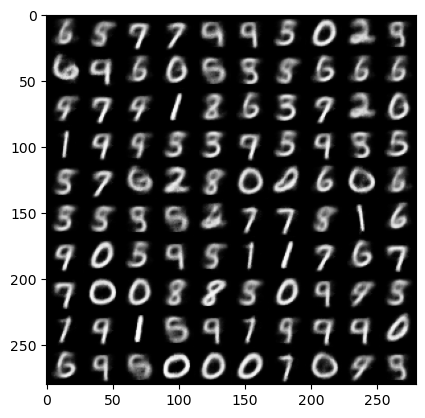

Negative log likelihood is 0.04107, mmd loss is 0.00558
Negative log likelihood is 0.04116, mmd loss is 0.00349
Negative log likelihood is 0.03909, mmd loss is 0.00476
Negative log likelihood is 0.03791, mmd loss is 0.00179
Negative log likelihood is 0.04205, mmd loss is 0.00799


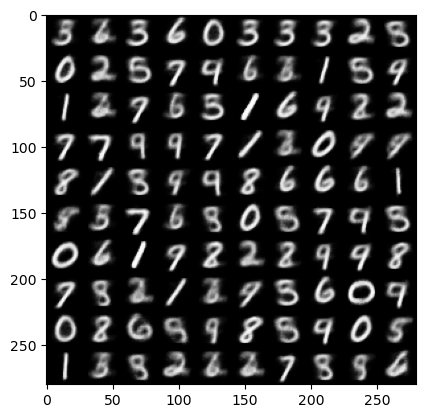

Negative log likelihood is 0.03739, mmd loss is 0.00736
Negative log likelihood is 0.04041, mmd loss is 0.00440
Negative log likelihood is 0.04128, mmd loss is 0.00318
Negative log likelihood is 0.03982, mmd loss is 0.00480


In [11]:
z_dim = 2
model = train(mnist_train, z_dim=z_dim, n_epochs=10,divergence='mmd')

In [12]:
import torchvision
mnist_dataset= torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))


0


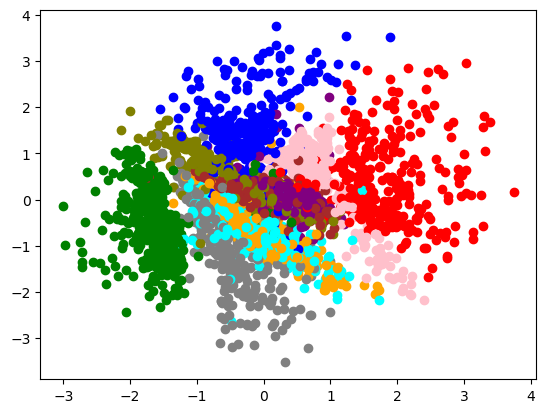

In [25]:
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
j=0
print(j)
for images,labels in mnist_train:
    j+=200
    #print(j)
    x = Variable(images, requires_grad=False)
    if torch.cuda.is_available():
        x = x.cuda()
    z,_=model(x)
    z = z.cpu().detach().numpy()
    for i in range(labels.shape[0])[:10]:
        label = labels[i].item()
        plt.scatter(z[i, 0], z[i, 1], c=colors[label], label=str(label))

plt.show()